# Creating Custom HMMs

Dynamax provides several built-in HMM models as you can see in the API, but sometimes you need a model that isn't already available. This notebook shows how to create a custom HMM. 

In this demo, we will construct an HMM with Poisson GLM emissions. Each discrete state will have its own weights. For illustrative purposes, we will require the weights to be **non-negative**.

\begin{align*}
p(y_t \mid x_{t}, z_t) &=
\prod_{d=1}^D \mathrm{Po}\left(\beta_{z_t,d}^\top x_t \right).
\end{align*}

where 
- $y_t \in \mathbb{N}^D$ is a vector of observed counts
- $z_t \in \{1,\ldots,K\}$ is the discrete state
- $x_t \in \mathbb{R}_+^M$ are the **non-negative** inputs
- $\beta_{k,d} \in \mathbb{R}_+^M$ are the **non-negative** weights for state $k$ and emission dimension $d$, and 

We assume independent exponential priors on the weights,

\begin{align*}
p(\beta) &= \prod_{k=1}^K \prod_{d=1}^D \mathrm{Exp}(\beta_{k,d} \mid \lambda).
\end{align*}

where $\lambda \in \mathbb{R}_+$ is the scale. 

We will use the default M-step, which updates the model parameters $\beta$ using stochastic gradient ascent. To enforce the non-negativity constraint, we will use a **bijector** to map the parameters to unconstrained real values.

## Setup

In [1]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [2]:
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import Float, Array
import matplotlib.pyplot as plt
import optax
import seaborn as sns
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb

from typing import NamedTuple, Optional, Tuple, Union

from dynamax.parameters import ParameterProperties
from dynamax.hidden_markov_model.models.abstractions import HMM, HMMEmissions, HMMParameterSet, HMMPropertySet
from dynamax.hidden_markov_model.models.initial import StandardHMMInitialState, ParamsStandardHMMInitialState
from dynamax.hidden_markov_model.models.transitions import StandardHMMTransitions, ParamsStandardHMMTransitions
from dynamax.types import IntScalar, Scalar
from dynamax.utils.plotting import gradient_cmap

C:\Users\danie\dynamax\dynamax\hidden_markov_model\models\multinomial_hmm.py:27: SyntaxWarning: invalid escape sequence '\g'
  """Multinomial emissions for an HMM.


### Helper functions for plotting

In [3]:
sns.set_style("white")

color_names = [
    "windows blue",
    "red",
    "amber",
    # "faded green",
    # "dusty purple",
    # "orange",
    # "brown",
    # "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

## Define the Poisson GLM emission model

First, we create a class for the Poisson GLM emissions and a NamedTuple for its parameters

The emissions object inherits from `HMMEmissions`, and it must implement a few functions:
- `emissions_shape` and `inputs_shape` properties.
- `initialize`: returns initial parameters and a corresponding set of properties. To implement the non-negativity constraint, we use a [TFP Bijector](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Bijector) that maps the weights to unconstrained real values before optimization.  Specifically, we use the [`Softplus`](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Softplus) bijector to map reals to non-negative reals.
- `log_prior`: computes the log prior probability for a given set of parameters. (This function is not strictly necessary since the base class assumes the log prior is zero.)
- `distribution`: returns a TFP distribution object specifying the likelihood, $p(y_t \mid x_t, z_t)$, for a given discrete state and input.



In [4]:
class ParamsPoissonGLMHMMEmissions(NamedTuple):
    """Parameters for the Poisson GLM emissions in an HMM."""
    weights: Union[Float[Array, "num_states emission_dim input_dim"], ParameterProperties]


class PoissonGLMHMMEmissions(HMMEmissions):
    r"""Poisson GLM emissions for an HMM.
    
    Args:
        num_states: number of discrete states $K$
        emission_dim: dimension of the emission distribution $D$
        input_dim: input dimension $M$
        emission_matrices_scale: $\varsigma$
        m_step_optimizer: ``optax`` optimizer, like Adam.
        m_step_num_iters: number of optimizer steps per M-step.
    """
    def __init__(self,
                 num_states: int,
                 emission_dim: int,
                 input_dim: int,
                 emission_matrices_scale: Scalar = 1.0,
                 m_step_optimizer: optax.GradientTransformation = optax.adam(1e-2),
                 m_step_num_iters: int = 50):
        super().__init__(m_step_optimizer=m_step_optimizer, m_step_num_iters=m_step_num_iters)
        self.num_states = num_states
        self.emission_dim = emission_dim
        self.input_dim = input_dim
        self.emission_weights_scale = emission_matrices_scale

    @property
    def emission_shape(self) -> Tuple:
        """Shape of the emission distribution."""
        return (self.emission_dim,)

    @property
    def inputs_shape(self) -> Tuple[int]:
        """Shape of the inputs to the emission distribution."""
        return (self.input_dim,)

    def initialize(self,
                   key: Array = jr.PRNGKey(0),
                   method: str = "prior",
                   emission_weights: Optional[Float[Array, "num_states emission_dim input_dim"]] = None,
                   ) -> Tuple[ParamsPoissonGLMHMMEmissions, ParamsPoissonGLMHMMEmissions]:
        """Initialize the model parameters and their corresponding properties.

        You can either specify parameters manually via the keyword arguments, or you can have
        them set automatically. If any parameters are not specified, you must supply a PRNGKey.

        Args:
            key: random number generator for unspecified parameters. Must not be None if there are any unspecified parameters.
            method: method for initializing unspecified parameters. Only "prior" is supported.
            emission_weights: manually specified emission weights.

        Returns:
            Model parameters and their properties.
        """
        if method.lower() == "prior":
            _emission_weights = tfd.Exponential(rate=1 / self.emission_weights_scale).sample(
                seed=key, sample_shape=(self.num_states, self.emission_dim, self.input_dim))

        else:
            raise Exception("Invalid initialization method: {}".format(method))

        # Only use the values above if the user hasn't specified their own
        default = lambda x, x0: x if x is not None else x0
        params = ParamsPoissonGLMHMMEmissions(
            weights=default(emission_weights, _emission_weights))
        props = ParamsPoissonGLMHMMEmissions(
            weights=ParameterProperties(constrainer=tfb.Softplus()))
        return params, props

    def log_prior(self, params: ParamsPoissonGLMHMMEmissions) -> Float[Array, ""]:
        """Log prior probability of the emission parameters."""
        return tfd.Exponential(rate=1 / self.emission_weights_scale).log_prob(
            params.weights).sum()

    def distribution(
            self,
            params: ParamsPoissonGLMHMMEmissions,
            state: IntScalar,
            inputs: Float[Array, " input_dim"]
            ) -> tfd.Distribution:
        """Emission distribution for a given state.
        
        *Note:* The inputs are assumed to be non-negative!
        """
        activations = params.weights[state] @ inputs
        return tfd.Independent(tfd.Poisson(rate=activations), 1)


## Create the Poisson GLM HMM object and corresponding parameters

Now we just need to create objects to combine the Poisson GLM emissions with standard HMM initial state and transition distributions.

This is pretty much just boilerplate code that you can copy and adjust as necessary. It's nice to expose the hyperparameters of the transition and emission models in the model constructor and initialization function.

In [5]:
class ParamsPoissonGLMHMM(NamedTuple):
    """Parameters for a Poisson GLM HMM."""
    initial: ParamsStandardHMMInitialState
    transitions: ParamsStandardHMMTransitions
    emissions: ParamsPoissonGLMHMMEmissions


class PoissonGLMHMM(HMM):
    r"""An HMM whose emissions come from a Poisson GLM with state-dependent weights.
    This is also known as a *Poisson GLM-HMM*.

    """
    def __init__(self,
                 num_states: int,
                 emission_dim: int,
                 input_dim: int,
                 initial_probs_concentration: Union[Scalar, Float[Array, " num_states"]]=1.1,
                 transition_matrix_concentration: Union[Scalar, Float[Array, " num_states"]]=1.1,
                 transition_matrix_stickiness: Scalar=0.0,
                 emission_matrices_scale: Scalar=1.0,
                 m_step_optimizer: optax.GradientTransformation=optax.adam(1e-2),
                 m_step_num_iters: int=50):
        self.inputs_dim = input_dim
        initial_component = StandardHMMInitialState(
            num_states, initial_probs_concentration=initial_probs_concentration)
        transition_component = StandardHMMTransitions(
            num_states, concentration=transition_matrix_concentration, 
            stickiness=transition_matrix_stickiness)
        emission_component = PoissonGLMHMMEmissions(
            num_states, emission_dim, input_dim, 
            emission_matrices_scale=emission_matrices_scale, 
            m_step_optimizer=m_step_optimizer, 
            m_step_num_iters=m_step_num_iters)
        super().__init__(num_states, initial_component, transition_component, emission_component)

    @property
    def inputs_shape(self) -> Tuple[int, ...]:
        """Shape of the inputs to the emission distribution."""
        return (self.inputs_dim,)

    def initialize(self,
                   key: Array=jr.PRNGKey(0),
                   method: str="prior",
                   initial_probs: Optional[Float[Array, " num_states"]]=None,
                   transition_matrix: Optional[Float[Array, "num_states num_states"]]=None,
                   emission_weights: Optional[Float[Array, "num_states input_dim"]]=None
        ) -> Tuple[HMMParameterSet, HMMPropertySet]:
        """Initialize the model parameters and their corresponding properties.
        """
        key1, key2, key3 = jr.split(key , 3)
        params, props = dict(), dict()
        params["initial"], props["initial"] = self.initial_component.initialize(
            key1, method=method, initial_probs=initial_probs)
        params["transitions"], props["transitions"] = self.transition_component.initialize(
            key2, method=method, transition_matrix=transition_matrix)
        params["emissions"], props["emissions"] = self.emission_component.initialize(
            key3, method=method, emission_weights=emission_weights)
        return ParamsPoissonGLMHMM(**params), ParamsPoissonGLMHMM(**props)


That's it! Now we can instantiate the model, and we inherit the base class's functions for samping and fitting the model.

## Simulate Data

In [6]:
# Make a Poisson GLM-HMM
init_key, sample_key = jr.split(jr.PRNGKey(0))
num_states = 3
emission_dim = 10
input_dim = 5

# Construct a simple, sticky transition matrix
transition_probs = (jnp.arange(num_states)**5).astype(float)
transition_probs /= transition_probs.sum()
transition_matrix = jnp.zeros((num_states, num_states))
for k, p in enumerate(transition_probs[::-1]):
    transition_matrix += jnp.roll(p * jnp.eye(num_states), k, axis=1)
    
# Construct the Poisson GLM-HMM and 
true_model = PoissonGLMHMM(num_states, emission_dim, input_dim)
true_params, _ = true_model.initialize(key=init_key, transition_matrix=transition_matrix)

# Generate random inputs
num_timesteps = 1000
inputs = tfd.Exponential(rate=1.0).sample(
    seed=sample_key, sample_shape=(num_timesteps, input_dim))

# Sample states and emissions from the model
true_states, emissions = true_model.sample(
    true_params, sample_key, num_timesteps, inputs=inputs)

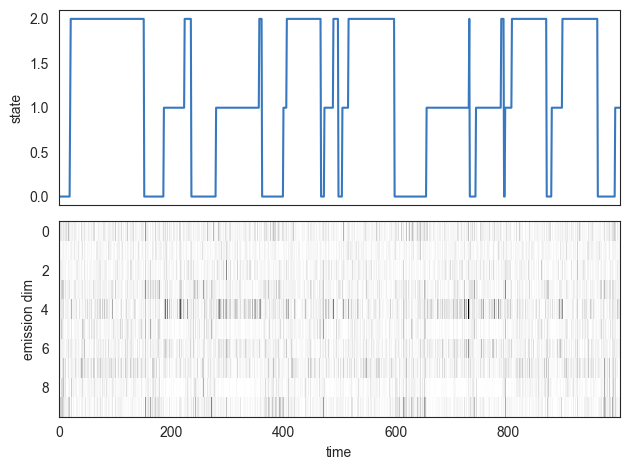

In [7]:
slc = slice(0, 1000)
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(true_states[slc], color=colors[0])
axs[0].set_ylabel("state")
axs[1].imshow(emissions[slc].T, cmap="Greys", aspect="auto", interpolation="none")
axs[1].set_ylabel("emission dim")
axs[1].set_xlabel("time")
plt.tight_layout()

## Fit the Model

The custom Poisson GLM-HMM inherits the fitting functions from the base class. By default, the M-step uses SGD to maximize the expected log likelihood. Let's see if we can recover the states and parameters using EM. 

In [8]:
# Now fit an HMM to the emissions
init_key = jr.PRNGKey(12345)
test_num_states = num_states

# Initialize with new random seed
model = PoissonGLMHMM(num_states=test_num_states, emission_dim=emission_dim, input_dim=input_dim)
params, props = model.initialize(key=init_key)

# Fit with EM
fitted_params, lps = model.fit_em(params=params, props=props, emissions=emissions, inputs=inputs)

### Plot the log likelihoods against the true likelihood, for comparison

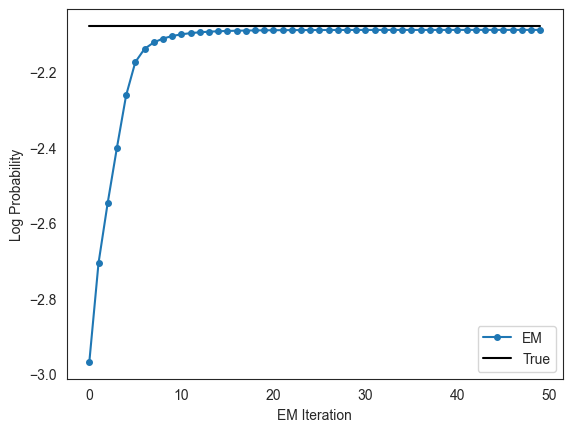

In [9]:
scale = emission_dim * num_timesteps
true_lp = model.marginal_log_prob(true_params, emissions, inputs=inputs)
plt.plot(lps / scale, '-o', ms=4, label="EM")
plt.plot(true_lp / scale * jnp.ones(len(lps)), '-k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

### Compare the true and inferred parameters

The emission weights are arrays of shape $K \times D \times M$ where $K$ is the number of states, $D$ is the emission dimension, and $M$ is the input dimension. The states should be approximately recovered, up to permutation of the discrete states. Here, it looks like inferred states 1 and 2 are swapped in the fitted model.

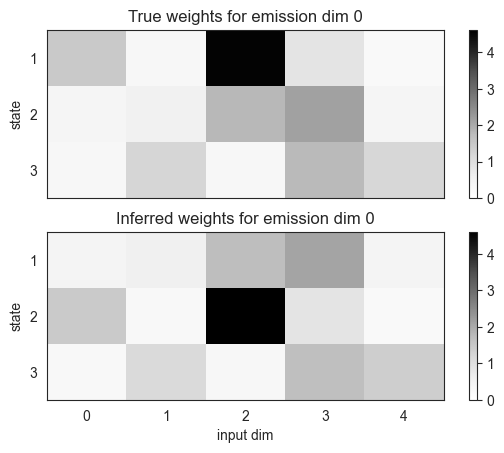

In [10]:
lim = max(true_params.emissions.weights.max(), 
          fitted_params.emissions.weights.max())

fig, axs = plt.subplots(2, 1, sharex=True)
im = axs[0].imshow(true_params.emissions.weights[:, 0, :], 
              cmap="Greys", aspect="auto", interpolation="none", vmin=0, vmax=lim)
axs[0].set_title("True weights for emission dim 0")
axs[0].set_ylabel("state")
axs[0].set_yticks(jnp.arange(num_states))
axs[0].set_yticklabels(jnp.arange(num_states) + 1)
plt.colorbar(im)

im = axs[1].imshow(fitted_params.emissions.weights[:, 0, :], 
              cmap="Greys", aspect="auto", interpolation="none", vmin=0, vmax=lim)
axs[1].set_title("Inferred weights for emission dim 0")
axs[1].set_xlabel("input dim")
axs[1].set_ylabel("state")
axs[1].set_yticks(jnp.arange(test_num_states))
axs[1].set_yticklabels(jnp.arange(test_num_states) + 1)
plt.colorbar(im)

### Plot the true and inferred discrete states

Now let's look at the posterior distribution over the latent states. We should see that the inferred states switch at the same time as the true states, but the labels of the states may be different.

In [11]:
# Compute the posterior distribution of the latent states
posterior = model.smoother(params=fitted_params, emissions=emissions, inputs=inputs)

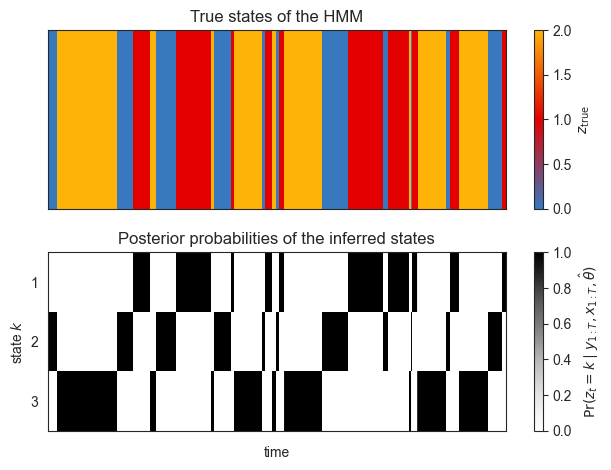

In [12]:
# Plot the true states and the posterior probability
plot_slice = (0, 1000)

fig, axs = plt.subplots(2, 1, sharex=True)
im = axs[0].imshow(true_states[None, :], aspect="auto", interpolation="none", cmap=cmap, vmin=0, vmax=len(colors)-1)
axs[0].set_xlim(plot_slice)
axs[0].set_xticklabels([])
axs[0].set_yticks([])
axs[0].set_title("True states of the HMM")
plt.colorbar(im, label=r"$z_{\mathrm{true}}$")

im = axs[1].imshow(posterior.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
axs[1].set_xlim(plot_slice)
axs[1].set_ylabel("state $k$")
axs[1].set_yticks(jnp.arange(test_num_states))
axs[1].set_yticklabels(jnp.arange(test_num_states) + 1)
axs[1].set_xlabel("time")
axs[1].set_title("Posterior probabilities of the inferred states")
plt.colorbar(im, label=r"$\Pr(z_t=k \mid y_{1:T}, x_{1:T}, \hat{\theta})$")

plt.tight_layout()

## Conclusion

This notebook showed how to construct a custom HMM and use functions inherited from the base class to sample and fit the model. In this case, we created a Poisson GLM-HMM with non-negative weights, which is a useful model in its own right. To respect the non-negativity constraints, we used a bijector to map between reals and non-negative reals. We needed some boilerplate code to complete the model, but overall it's pretty straightforward to create your own models!